In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import F1Score
from tqdm import tqdm

BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = 'preprocessed_brain_mri_dataset'

Loading pituitary: 100%|████████████████████████████████████████████████████████████| 667/667 [00:01<00:00, 633.87it/s]


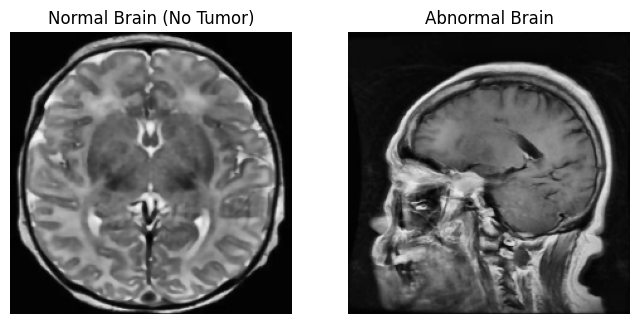

In [3]:
images = []
labels = []

normal_class = 'notumor'
abnormal_classes = [c for c in os.listdir(DATA_DIR) if c != normal_class]

# Load normal images
normal_images = []
for img_name in tqdm(os.listdir(os.path.join(DATA_DIR, normal_class)), desc=f'Loading {normal_class}'):
    if img_name.lower().endswith('.jpg'):
        img_path = os.path.join(DATA_DIR, normal_class, img_name)
        img = load_img(img_path, target_size=(224,224))
        img_array = img_to_array(img) / 255.0
        normal_images.append(img_array)

# Load abnormal images and undersample each class to 667
abnormal_images = []
for label in abnormal_classes:
    folder = os.path.join(DATA_DIR, label)

    img_names = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    img_names = shuffle(img_names, random_state=42)[:667]

    for img_name in tqdm(img_names, desc=f'Loading {label}'):
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path)
        img_array = img_to_array(img) / 255.0
        abnormal_images.append(img_array)

normal_img = random.choice(normal_images)
abnormal_img = random.choice(abnormal_images)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(normal_img)
plt.title("Normal Brain (No Tumor)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(abnormal_img)
plt.title("Abnormal Brain")
plt.axis("off")
plt.show()

In [6]:
# Combine normal and abnormal
images = np.array(normal_images + abnormal_images)
labels = np.array([0]*len(normal_images) + [1]*len(abnormal_images))  # 0=normal, 1=abnormal

# Shuffle dataset
images, labels = shuffle(images, labels, random_state=42)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.1, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [7]:
# Model
img_input = layers.Input(shape=(224,224,3))
base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

base.trainable = False  # recommended for first training phase

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(average='macro')
    ]
)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

C:\Users\user\AppData\Local\Temp\ipykernel_23768\4067393934.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - accuracy: 0.9111 - f1_score: 0.9111 - loss: 0.2308 - precision: 0.9111 - recall: 0.9111 - val_accuracy: 0.9444 - val_f1_score: 0.9444 - val_loss: 0.1341 - val_precision: 0.9444 - val_recall: 0.9444
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.9618 - f1_score: 0.9618 - loss: 0.1100 - precision: 0.9618 - recall: 0.9618 - val_accuracy: 0.9653 - val_f1_score: 0.9653 - val_loss: 0.1098 - val_precision: 0.9653 - val_recall: 0.9653
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.9750 - f1_score: 0.9750 - loss: 0.0861 - precision: 0.9750 - recall: 0.9750 - val_accuracy: 0.9639 - val_f1_score: 0.9638 - val_loss: 0.1159 - val_precision: 0.9639 - val_recall: 0.9639
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 388ms/step - accuracy: 0.9795 - f1_score: 0.9795 - loss: 0.0590 - precision: 0.9795 - recall: 0.9795 - val_accuracy: 0.9819 - val_f1_score: 0.9819 - val_loss: 0.0601 - val_precision: 0.9819 - val_rec

In [8]:
# Keras and h5 format
model.save('downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_preprocessed.h5')
model.save('downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_preprocessed.keras')

# TensorFlow SavedModel format (folder)
model.export('downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_folder_preprocessed')

INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_folder_preprocessed\assets


INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_folder_preprocessed\assets


Saved artifact at 'downloaded_models/mobilenetv2/binary_classifier_preprocessed/binary_brain_mri_model_folder_preprocessed'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1914192218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237440144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237441872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237441488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237439952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237442064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237440528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237442640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237442256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1915237440336: 